In [1]:
# Full library list and version numbers

print('This notebook was prepared using:')

import sys
print('python version %s' % sys.version)

import numpy as np
print('numpy version %s' % np.__version__)

import scipy as sp
print('scipy version %s' % sp.__version__)

import pandas as pd
print('pandas version %s' % pd.__version__)

import sklearn as sk
from sklearn.metrics import roc_auc_score

import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.image as mpimg
print('matplotlib version %s' % matplotlib.__version__)

from scipy import integrate
import scipy.interpolate as sp_interpolate

import importlib
from importlib import reload
import random
import seaborn as sns
import re

import simulation as sim
import figures as fig
import mplot as mp

# GitHub directories
HIV_DIR = 'data/HIV'
MPL_DIR = 'src/MPL'
SIM_DIR = 'data/simulation'
FIG_DIR = 'figures'
HIV_MPL_DIR = 'src/MPL/HIV'

# GitHub directories
HIV_DIR = 'data/HIV'
MPL_DIR = 'src/MPL'
SIM_DIR = 'data/simulation'
FIG_DIR = 'figures'

This notebook was prepared using:
python version 3.10.9 | packaged by conda-forge | (main, Feb  2 2023, 20:26:08) [Clang 14.0.6 ]
numpy version 1.24.2
scipy version 1.10.1
pandas version 1.5.3
matplotlib version 3.7.1


#### different constant r for HIV data

"src/rx_HIV_R.sh" : running MPL code for all HIV data with different recombination rates

In [2]:
# Define the start and end points in log10 space
start = np.log10(1.4e-6)
end = np.log10(1.4e-3)

# Number of points you want in the array
num_points = 16

# Generate the array with equal log steps
log_space_array = np.logspace(start, end, num=num_points)

trait_tags = ['700010040-3', '700010058-3', '700010077-3', '700010470-3', '700010470-5', '700010607-3', 
              '703010131-3', '703010131-5', '703010159-3', '703010256-3', '703010256-5', '704010042-3', 
              '705010162-3', '705010162-5', '705010185-5', '705010198-3', '706010164-3']  

special_tags = ['700010077-3', '705010162-3']

f = open("src/rx_HIV_R.sh",'w')
f.write('g++ main.cpp inf.cpp io.cpp -O3 -mcpu=apple-a14 -std=c++11 -lgsl -lgslcblas -o mpl\n')

for tag in trait_tags:
    if tag not in special_tags:
        for i in range(len(log_space_array)):
            r_rate = log_space_array[i]
            
            f.write('./mpl -d ../data/HIV -i input/sequence/%s-poly-seq2state.dat '%tag)
            f.write('-o rx/outputR/sc-%d-%s.dat -g 10 -m input/Zanini-extended.dat -rr %.2e '%(i,tag,r_rate))
            f.write('-e input/traitsite/traitsite-%s.dat -es input/traitseq/traitseq-%s.dat '%(tag,tag))
            f.write('-ed input/traitdis/traitdis-%s.dat\n'%tag)
    
# special case (escape sites contain nonsysnmous mutations)
f.write('g++ main.cpp inf_special.cpp io.cpp -O3 -mcpu=apple-a14 -std=c++11 -lgsl -lgslcblas -o mpl\n')
for tag in special_tags:
    for i in range(len(log_space_array)):
        r_rate = log_space_array[i]
        
        f.write('./mpl -d ../data/HIV -i input/sequence/%s-poly-seq2state.dat '%tag)
        f.write('-o rx/outputR/sc-%d-%s.dat -g 10 -m input/Zanini-extended.dat -rr %.2e '%(i,tag,r_rate))
        f.write('-e input/traitsite/traitsite-%s.dat -es input/traitseq/traitallele-%s.dat '%(tag,tag))
        f.write('-ed input/traitdis/traitdis-%s.dat\n'%tag)


f.close()

In [3]:
def write_output(tag,r_rates):

    # original file
    df_poly = pd.read_csv('%s/analysis/%s-analyze.csv' %(HIV_DIR,tag), comment='#', memory_map=True)

    for i in range(len(r_rates)):
        sc_new  = np.loadtxt('%s/outputR/sc-%d-%s.dat'%(HIV_DIR,i,tag))

        sc_MPL_new = np.zeros(len(df_poly))

        for ii in range(len(df_poly)):
            polymorphic_index = df_poly.iloc[ii].polymorphic_index
            nucleotide        = df_poly.iloc[ii].nucleotide
            TF                = df_poly.iloc[ii].TF

            # get selection coefficient for individual locus
            nuc_index  = NUC.index(nucleotide) + polymorphic_index*5
            TF_index   = NUC.index(TF) + polymorphic_index*5
            sc_MPL_new[ii] = sc_new[nuc_index] - sc_new[TF_index]

        # add new column
        df_poly['sc_%d'%i] = sc_MPL_new

    # save to new file
    df_poly.to_csv('%s/rx/different r/%s-analyze-R.csv'%(HIV_DIR,tag), index=False, na_rep='nan')

In [4]:
def write_output_trait(tag,r_rates):

    # original file
    df_trait    = pd.read_csv('%s/group/escape_group-%s.csv' %(HIV_DIR,tag), comment='#', memory_map=True)
    
    seq        = np.loadtxt('%s/input/sequence/%s-poly-seq2state.dat'%(HIV_DIR,tag))
    seq_length = len(seq[0]) - 2
    
    for i in range(len(r_rates)):
        sc_new  = np.loadtxt('%s/outputR/sc-%d-%s.dat'%(HIV_DIR,i,tag))

        trait_index = -1
        tc_0        = 0.0

        tc_MPL_new = np.zeros(len(df_trait)) 
        for ii in range(len(df_trait)):
            if df_trait.iloc[ii].tc_MPL != tc_0:
                trait_index += 1

            tc_MPL_new[ii] = sc_new[seq_length * 5 + trait_index]
            tc_0     = df_trait.iloc[ii].tc_MPL

        # add new column
        df_trait['tc_%d'%i] = tc_MPL_new

    # save to new file
    df_trait.to_csv('%s/rx/different r/escape_group-R-%s.csv'%(HIV_DIR,tag), index=False, na_rep='nan')

In [5]:
'Different constant r in equal log steps '

# Define the start and end points in log10 space
start = np.log10(1.4e-6)
end = np.log10(1.4e-3)

# Number of points you want in the array
num_points = 16 # for example, change this value as needed

# Generate the array with equal log steps
r_rates = np.logspace(start, end, num=num_points)

for i in range(len(r_rates)):
    print('%.2e'%r_rates[i],end = ', ')

1.40e-06, 2.22e-06, 3.52e-06, 5.57e-06, 8.83e-06, 1.40e-05, 2.22e-05, 3.52e-05, 5.57e-05, 8.83e-05, 1.40e-04, 2.22e-04, 3.52e-04, 5.57e-04, 8.83e-04, 1.40e-03, 

In [6]:
NUC = ['-', 'A', 'C', 'G', 'T']

trait_tags = ['700010040-3', '700010058-3', '700010077-3', '700010470-3', '700010470-5', '700010607-3', 
              '703010131-3', '703010131-5', '703010159-3', '703010256-3', '703010256-5', '704010042-3', 
              '705010162-3', '705010162-5', '705010185-5', '705010198-3', '706010164-3']  

for tag in trait_tags:
    write_output(tag,r_rates)
    write_output_trait(tag,r_rates)    

Figure saved as rxfig-different-r.pdf


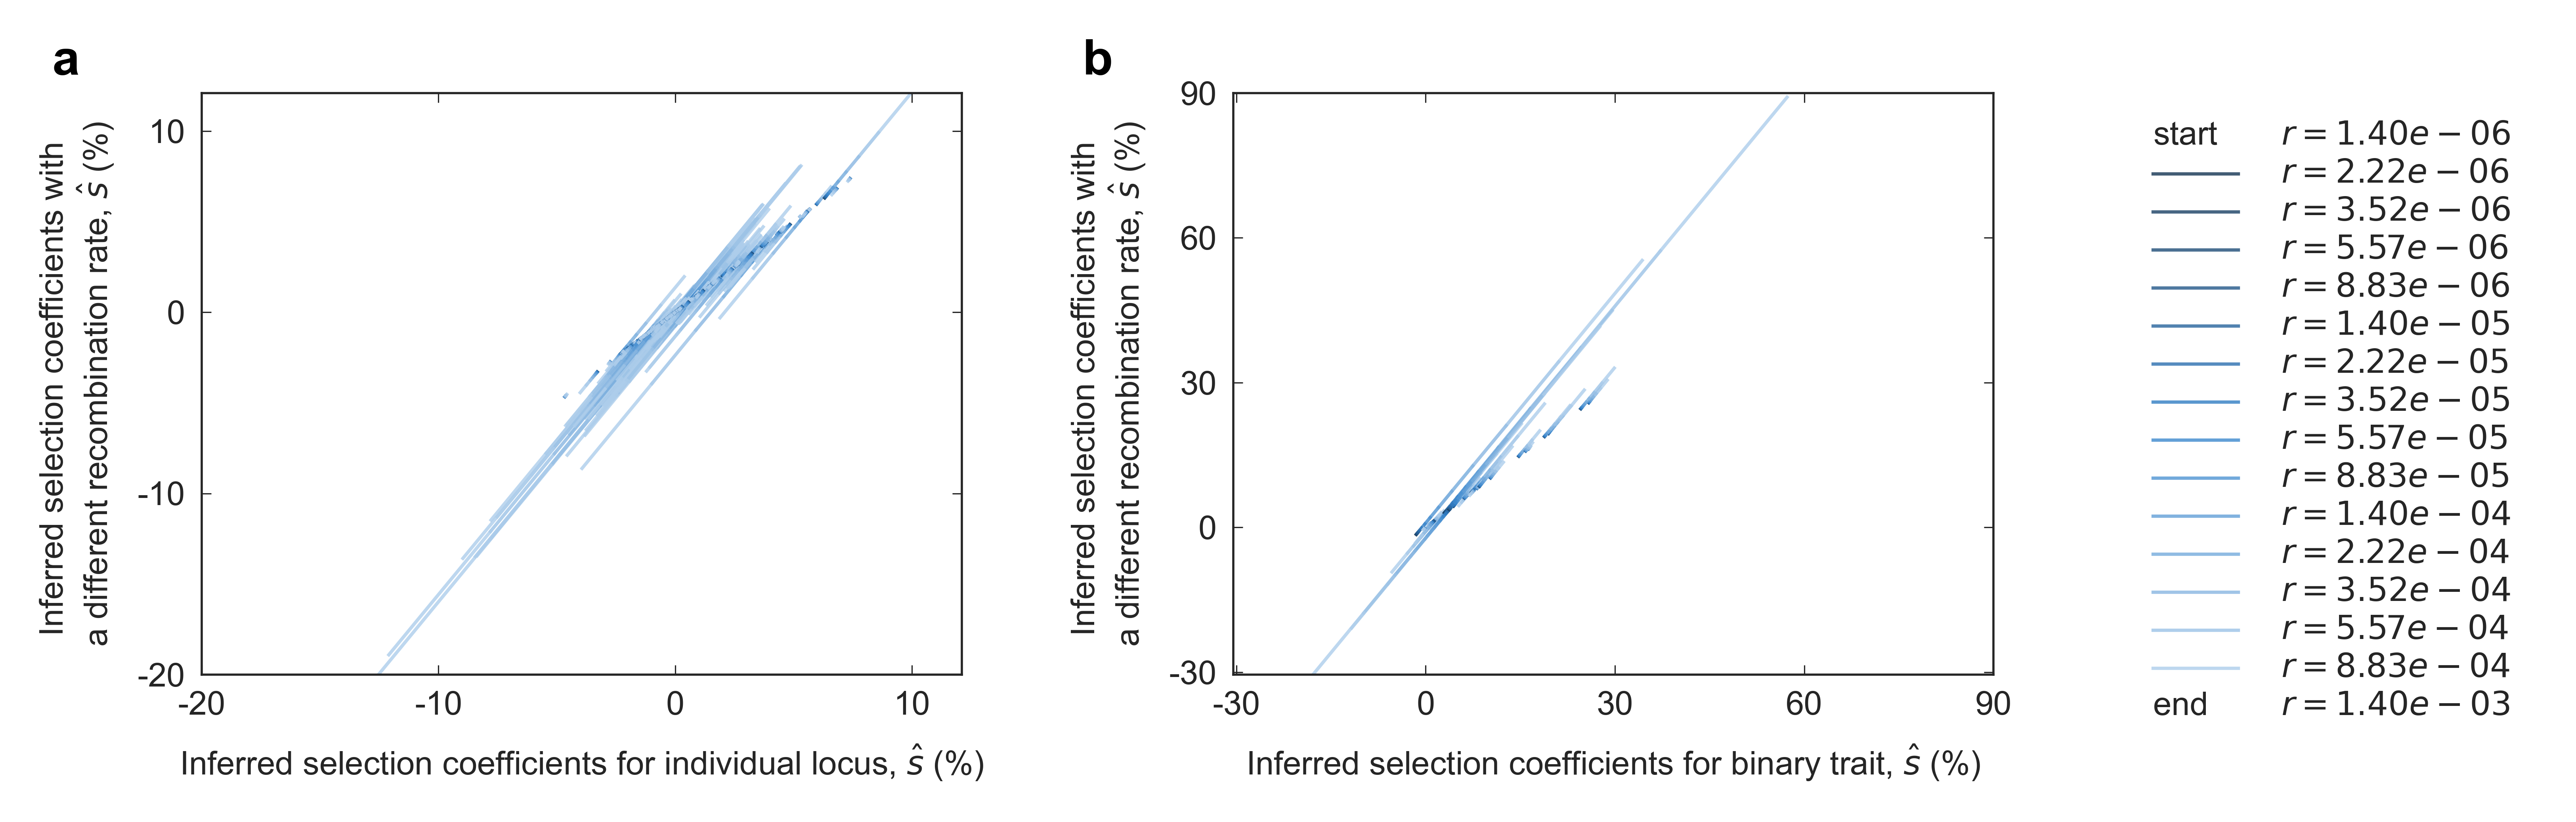

In [7]:
importlib.reload(mp)
importlib.reload(fig)


start = np.log10(1.4e-6)
end = np.log10(1.4e-3)

# Number of points you want in the array
num_points = 16

# Generate the array with equal log steps
r_rates = np.logspace(start, end, num=num_points)

pdata = {
    'tags': trait_tags,
    'r_rates':r_rates,
    'lim_sc':[ -0.20, 0.121],
    'lim_tc':[-0.305, 0.90],
    'tick_sc':[-0.2, -0.1, 0, 0.1],
    'tick_tc':[-0.3, 0, 0.3, 0.6, 0.9],
    
}

fig.plot_different_r(**pdata)


Figure saved as rxfig-different-r-tc.pdf


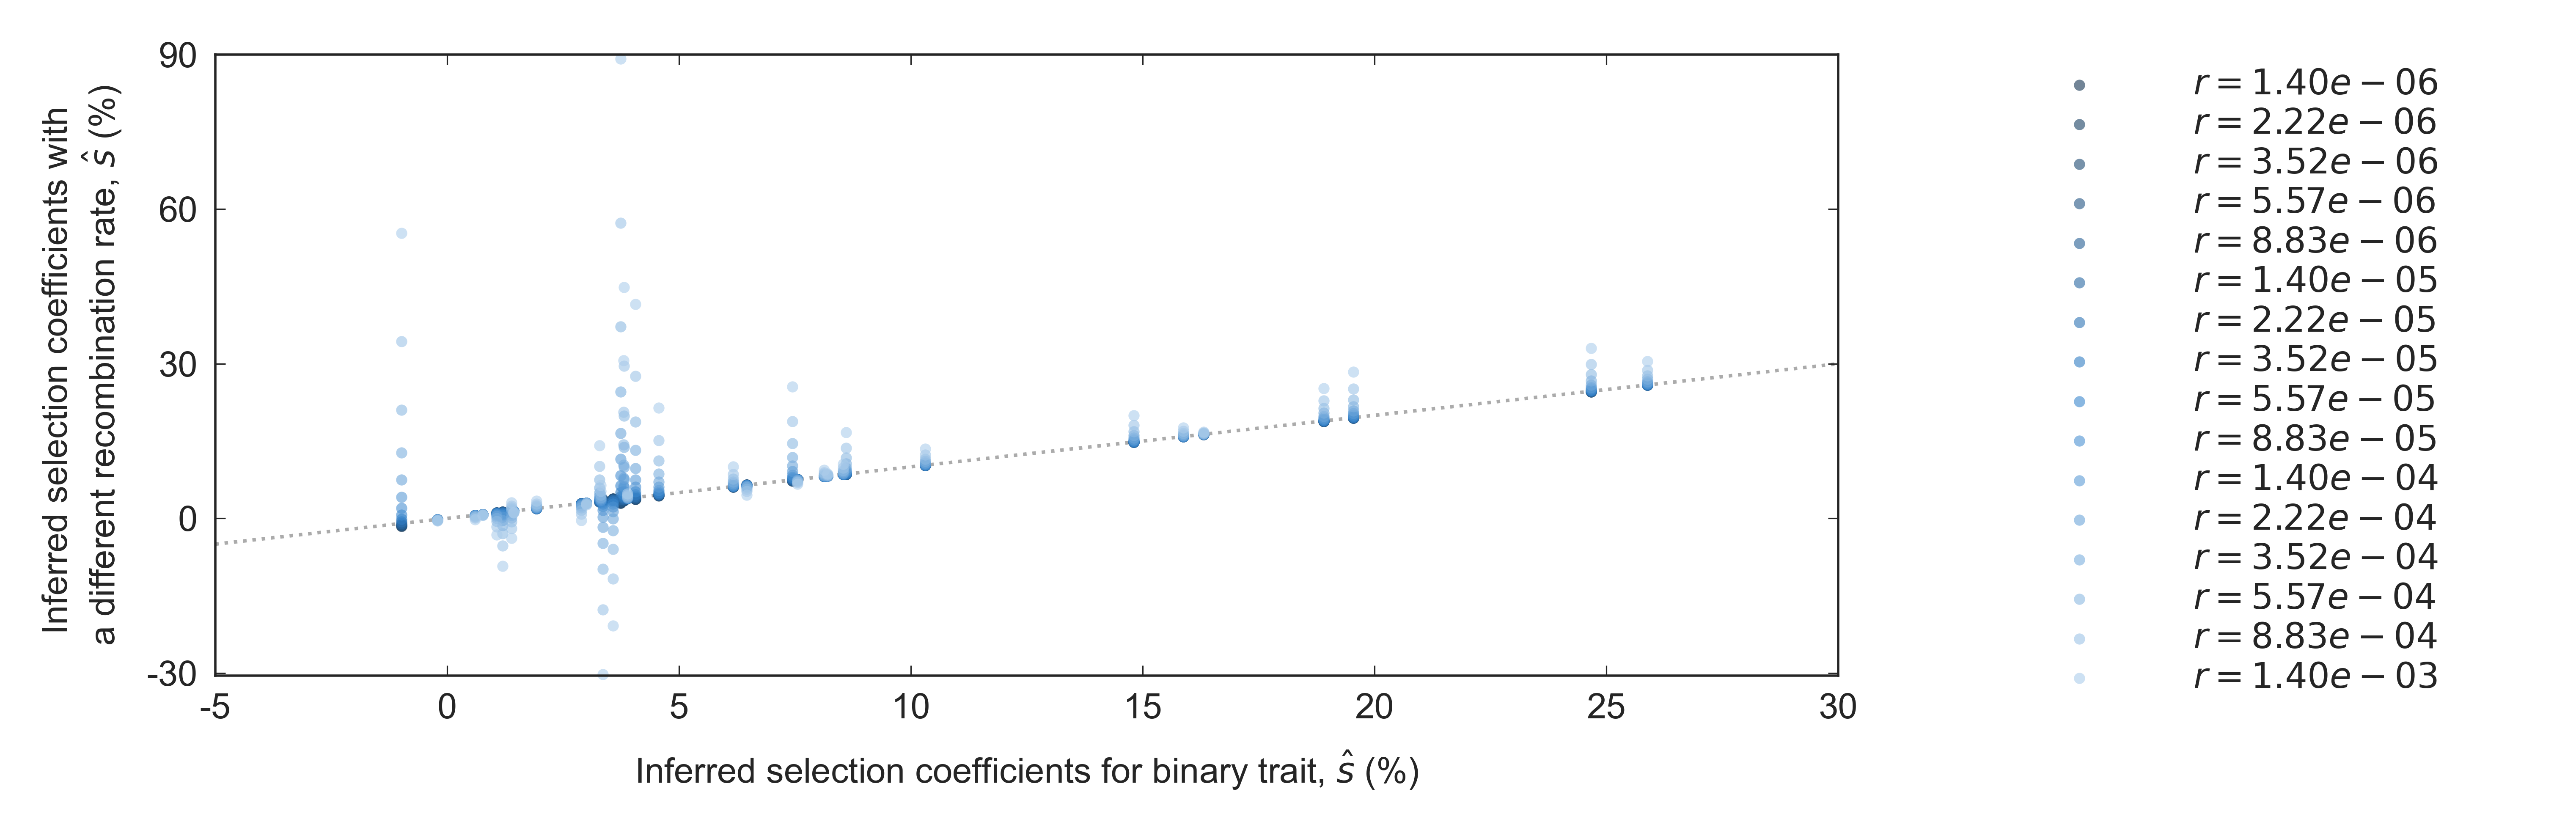

In [8]:
importlib.reload(mp)
importlib.reload(fig)


start = np.log10(1.4e-6)
end = np.log10(1.4e-3)

# Number of points you want in the array
num_points = 16

# Generate the array with equal log steps
r_rates = np.logspace(start, end, num=num_points)

pdata = {
    'tags': trait_tags,
    'r_rates':r_rates,
    'index': 5,
    'lim_tc_x':[-0.05, 0.30],
    'lim_tc_y':[-0.305, 0.90],
    'tick_tc_x':[-0.05, 0, 0.05, 0.10, 0.15, 0.20, 0.25,0.30],
    'tick_tc_y':[-0.3, 0, 0.3, 0.6, 0.9],
    
}

fig.plot_different_r_tc(**pdata)

#### Relationship between virus load and recombination rate

Figure saved as rxfig-vl.pdf


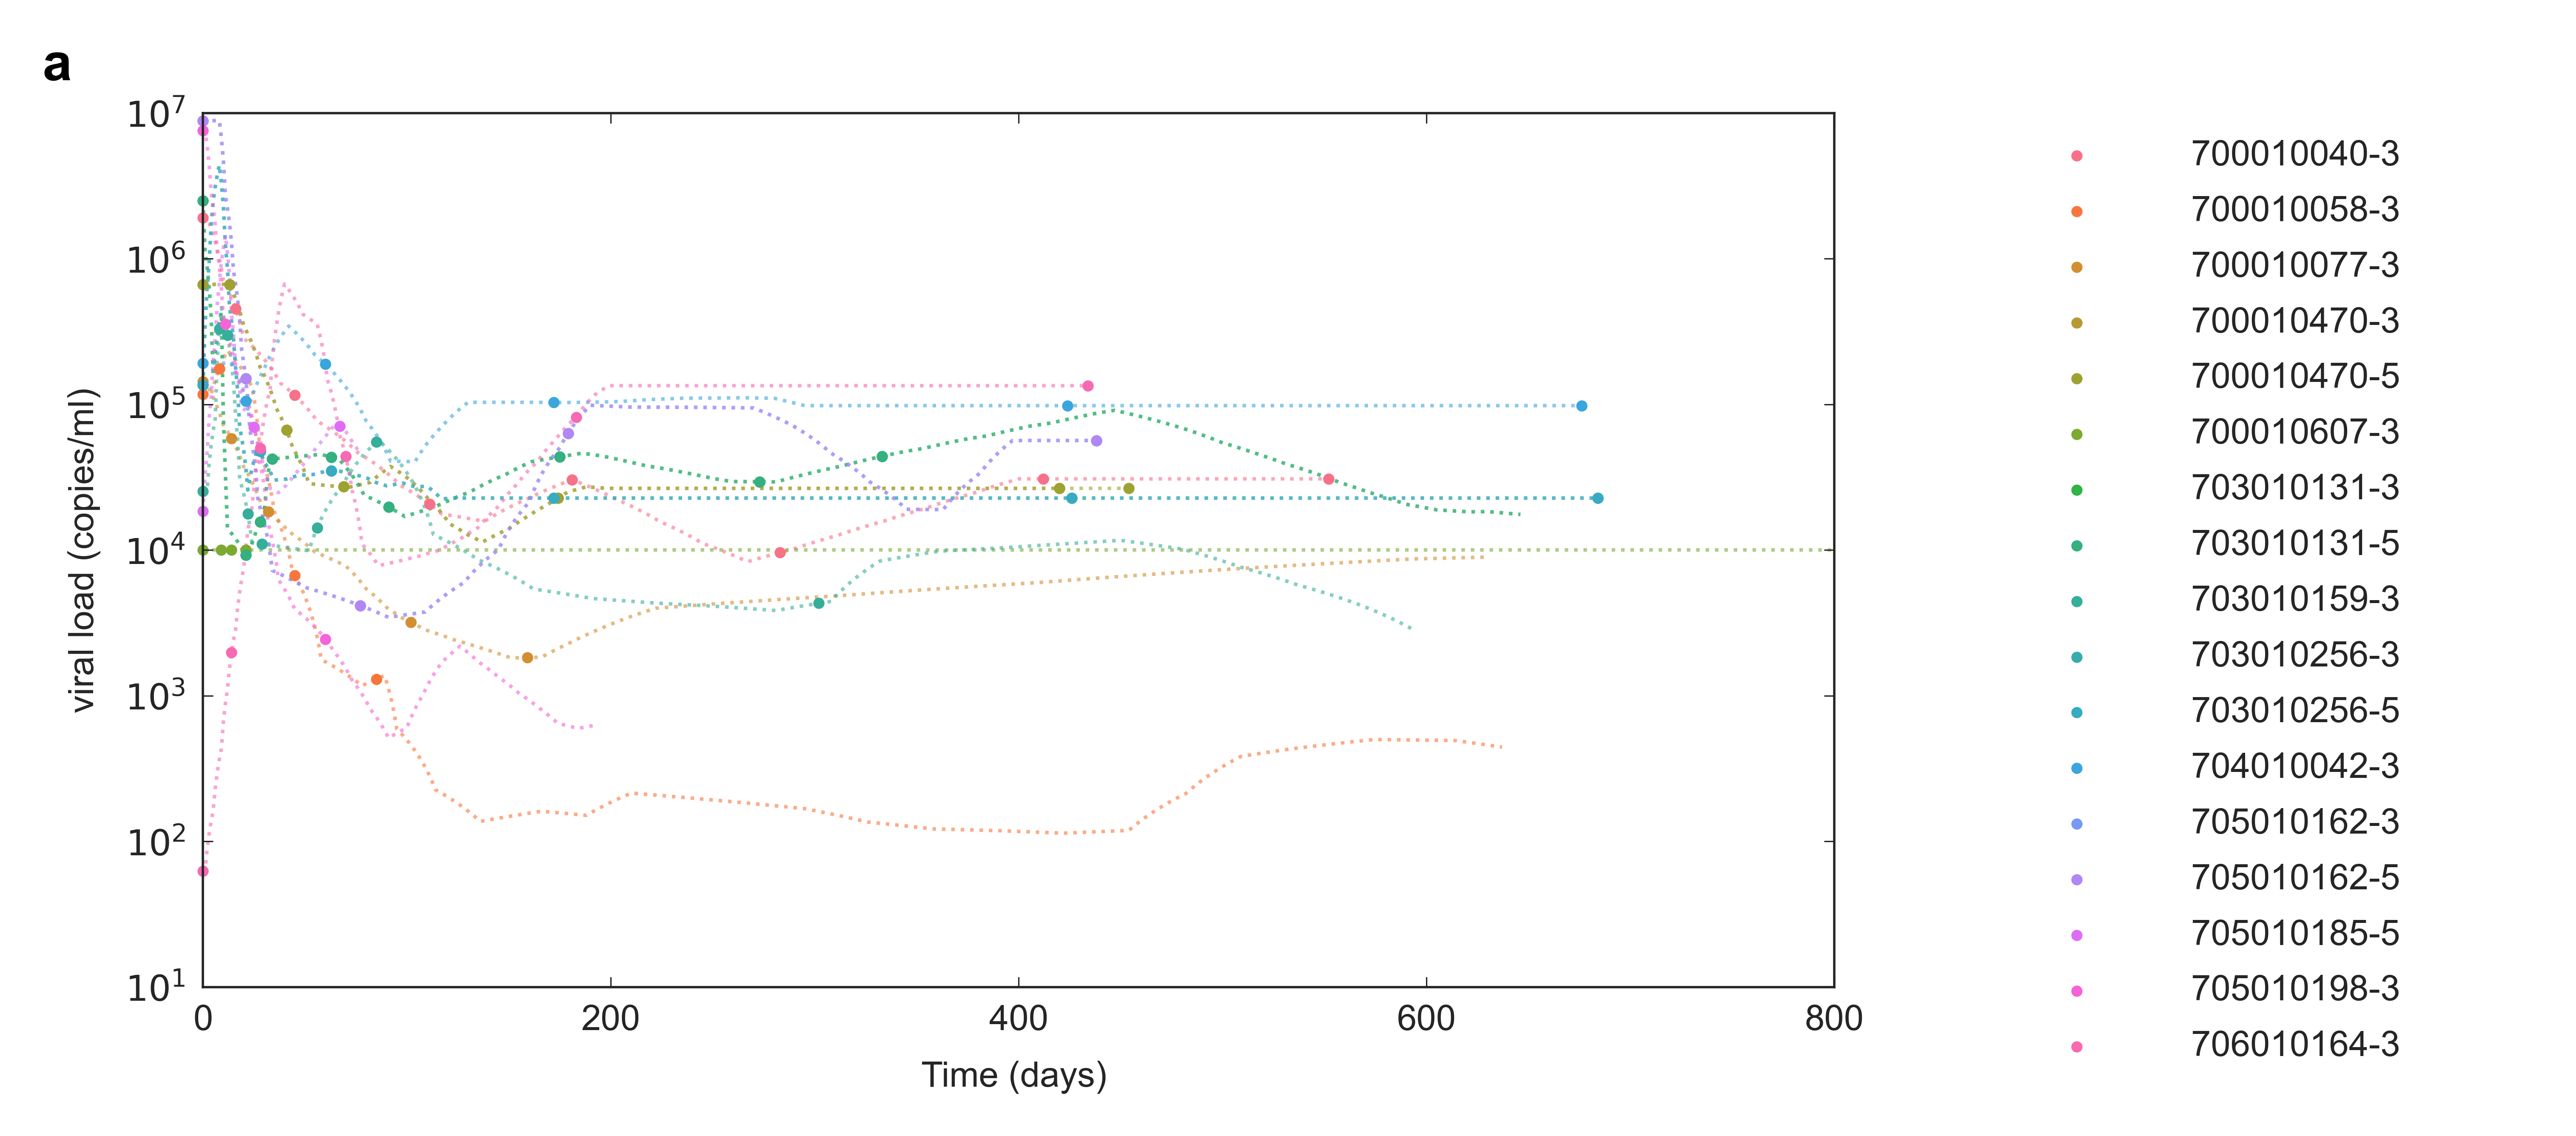

In [9]:
'Figure for virus load at different times'

importlib.reload(mp)
importlib.reload(fig)

trait_tags = ['700010040-3', '700010058-3', '700010077-3', '700010470-3', '700010470-5', '700010607-3', 
              '703010131-3', '703010131-5', '703010159-3', '703010256-3', '703010256-5', '704010042-3', 
              '705010162-3', '705010162-5', '705010185-5', '705010198-3', '706010164-3']  

pdata = {
    'tags': trait_tags,    
}

fig.plot_virus_load(**pdata)

Slope (Coefficient): 1.7218641160666025e-06
Intercept: 0.13916571137926576


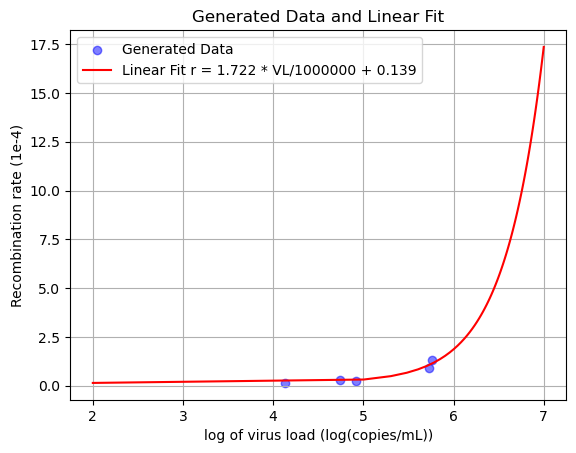

In [10]:
'Use a linear fitting to describe the relationship between VL and r'

from sklearn.linear_model import LinearRegression

x_simple_raw = [13400,54400,541000,82750,582750]
x_simple = np.array(x_simple_raw)
x_reshaped = x_simple.reshape(-1, 1)
y_simple = [0.15,0.28,0.9,0.26,1.3]
model = LinearRegression()
model.fit(x_reshaped, y_simple)

x_fitted = np.linspace(100, 10000000, 100)
y_fitted = model.predict(x_fitted.reshape(-1, 1))

# Output the fitted linear equation parameters
print(f"Slope (Coefficient): {model.coef_[0]}")
print(f"Intercept: {model.intercept_}")

# Visualize the results
plt.scatter(np.log10(x_simple), y_simple, color='blue', alpha=0.5, label='Generated Data')
plt.plot(np.log10(x_fitted), y_fitted, color='red', label=f'Linear Fit r = {model.coef_[0]*1000000:.3f} * VL/1000000 + {model.intercept_:.3f}')
plt.xlabel("log of virus load (log(copies/mL))")
plt.ylabel("Recombination rate (1e-4)")
plt.title("Generated Data and Linear Fit")
plt.grid(True)
plt.legend()
plt.show()

#### use a constant recombination rate to run the data
"src/HIV_cR.sh" : running MPL code for all HIV data with a constant recombination rates

In [11]:
f = open("src/rx_HIV_cR.sh",'w')
f.write('g++ main.cpp inf.cpp io.cpp -O3 -mcpu=apple-a14 -std=c++11 -lgsl -lgslcblas -o mpl\n')
for tag in trait_tags:
    if tag not in special_tags:
        f.write('./mpl -d ../data/HIV -i input/sequence/%s-poly-seq2state.dat '%tag)
        f.write('-o rx/outputcR/sc-%s.dat -g 10 -m input/Zanini-extended.dat -rr 1.4e-5 '%tag)
        f.write('-e input/traitsite/traitsite-%s.dat -es input/traitseq/traitseq-%s.dat '%(tag,tag))
        f.write('-ed input/traitdis/traitdis-%s.dat\n'%tag)

f.write('g++ main.cpp inf_special.cpp io.cpp -O3 -mcpu=apple-a14 -std=c++11 -lgsl -lgslcblas -o mpl\n')
# special case (escape sites contain nonsysnmous mutations)
for tag in special_tags:
    f.write('./mpl -d ../data/HIV -i input/sequence/%s-poly-seq2state.dat '%tag)
    f.write('-o rx/outputcR/sc-%s.dat -g 10 -m input/Zanini-extended.dat -rr 1.4e-5 '%tag)
    f.write('-e input/traitsite/traitsite-%s.dat -es input/traitseq/traitallele-%s.dat '%(tag,tag))
    f.write('-ed input/traitdis/traitdis-%s.dat\n'%tag)

f.close()

compare the result with VL-dependent r

In [12]:
NUC = ['-', 'A', 'C', 'G', 'T']

def write_output(tag):
    
    # original file
    df_poly = pd.read_csv('%s/analysis/%s-analyze.csv' %(HIV_DIR,tag), comment='#', memory_map=True)
    sc_cR  = np.loadtxt('%s/rx/outputcR/sc-%s.dat'%(HIV_DIR,tag))
    
    seq        = np.loadtxt('%s/input/sequence/%s-poly-seq2state.dat'%(HIV_DIR,tag))
    seq_length = len(seq[0]) - 2
    
    sc_MPL_new = np.zeros(len(df_poly))
    tc_MPL_new = ['nan'] * len(df_poly)  # define the inserted column
    
    trait_index = -1
    tc_0        = 0.0
    for ii in range(len(df_poly)):
        polymorphic_index = df_poly.iloc[ii].polymorphic_index
        nucleotide        = df_poly.iloc[ii].nucleotide
        TF                = df_poly.iloc[ii].TF

        # get selection coefficient for individual locus
        nuc_index  = NUC.index(nucleotide) + polymorphic_index*5
        TF_index   = NUC.index(TF) + polymorphic_index*5
        sc_MPL_new[ii] = sc_cR[nuc_index] - sc_cR[TF_index]
    
        # get selection coefficient for binary trait
        
        if pd.notna(df_poly.iloc[ii].tc_MPL):
            if df_poly.iloc[ii].tc_MPL != tc_0:
                trait_index += 1

            tc_MPL_new[ii] = sc_cR[seq_length * 5 + trait_index]
            tc_0     = df_poly.iloc[ii].tc_MPL

    # add new column
    df_poly.insert(10, 'sc_cR', sc_MPL_new)
    df_poly.insert(12, 'tc_cR', tc_MPL_new)

    # save to new file
    df_poly.to_csv('%s/rx/constant r/%s-analyze.csv'%(HIV_DIR,tag), index=False, na_rep='nan')


In [13]:
def write_output_trait(tag):

    # original file
    df_trait    = pd.read_csv('%s/group/escape_group-%s.csv' %(HIV_DIR,tag), comment='#', memory_map=True)
    
    seq        = np.loadtxt('%s/input/sequence/%s-poly-seq2state.dat'%(HIV_DIR,tag))
    seq_length = len(seq[0]) - 2
    
    sc_cR  = np.loadtxt('%s/rx/outputcR/sc-%s.dat'%(HIV_DIR,tag))
    tc_MPL_new = np.zeros(len(df_trait))  # define the inserted column

    trait_index = -1
    tc_0        = 0.0

    tc_MPL_new = np.zeros(len(df_trait)) 
    for ii in range(len(df_trait)):
        if df_trait.iloc[ii].tc_MPL != tc_0:
            trait_index += 1

        tc_MPL_new[ii] = sc_cR[seq_length * 5 + trait_index]
        tc_0     = df_trait.iloc[ii].tc_MPL
    
    # add new column
    df_trait.insert(10, 'tc_cR', tc_MPL_new)

    # save to new file
    df_trait.to_csv('%s/rx/constant r/escape_group-%s.csv'%(HIV_DIR,tag), index=False, na_rep='nan')

In [14]:
NUC = ['-', 'A', 'C', 'G', 'T']

trait_tags = ['700010040-3', '700010058-3', '700010077-3', '700010470-3', '700010470-5', '700010607-3', 
              '703010131-3', '703010131-5', '703010159-3', '703010256-3', '703010256-5', '704010042-3', 
              '705010162-3', '705010162-5', '705010185-5', '705010198-3', '706010164-3']  

for tag in trait_tags:
    write_output(tag)
    write_output_trait(tag)

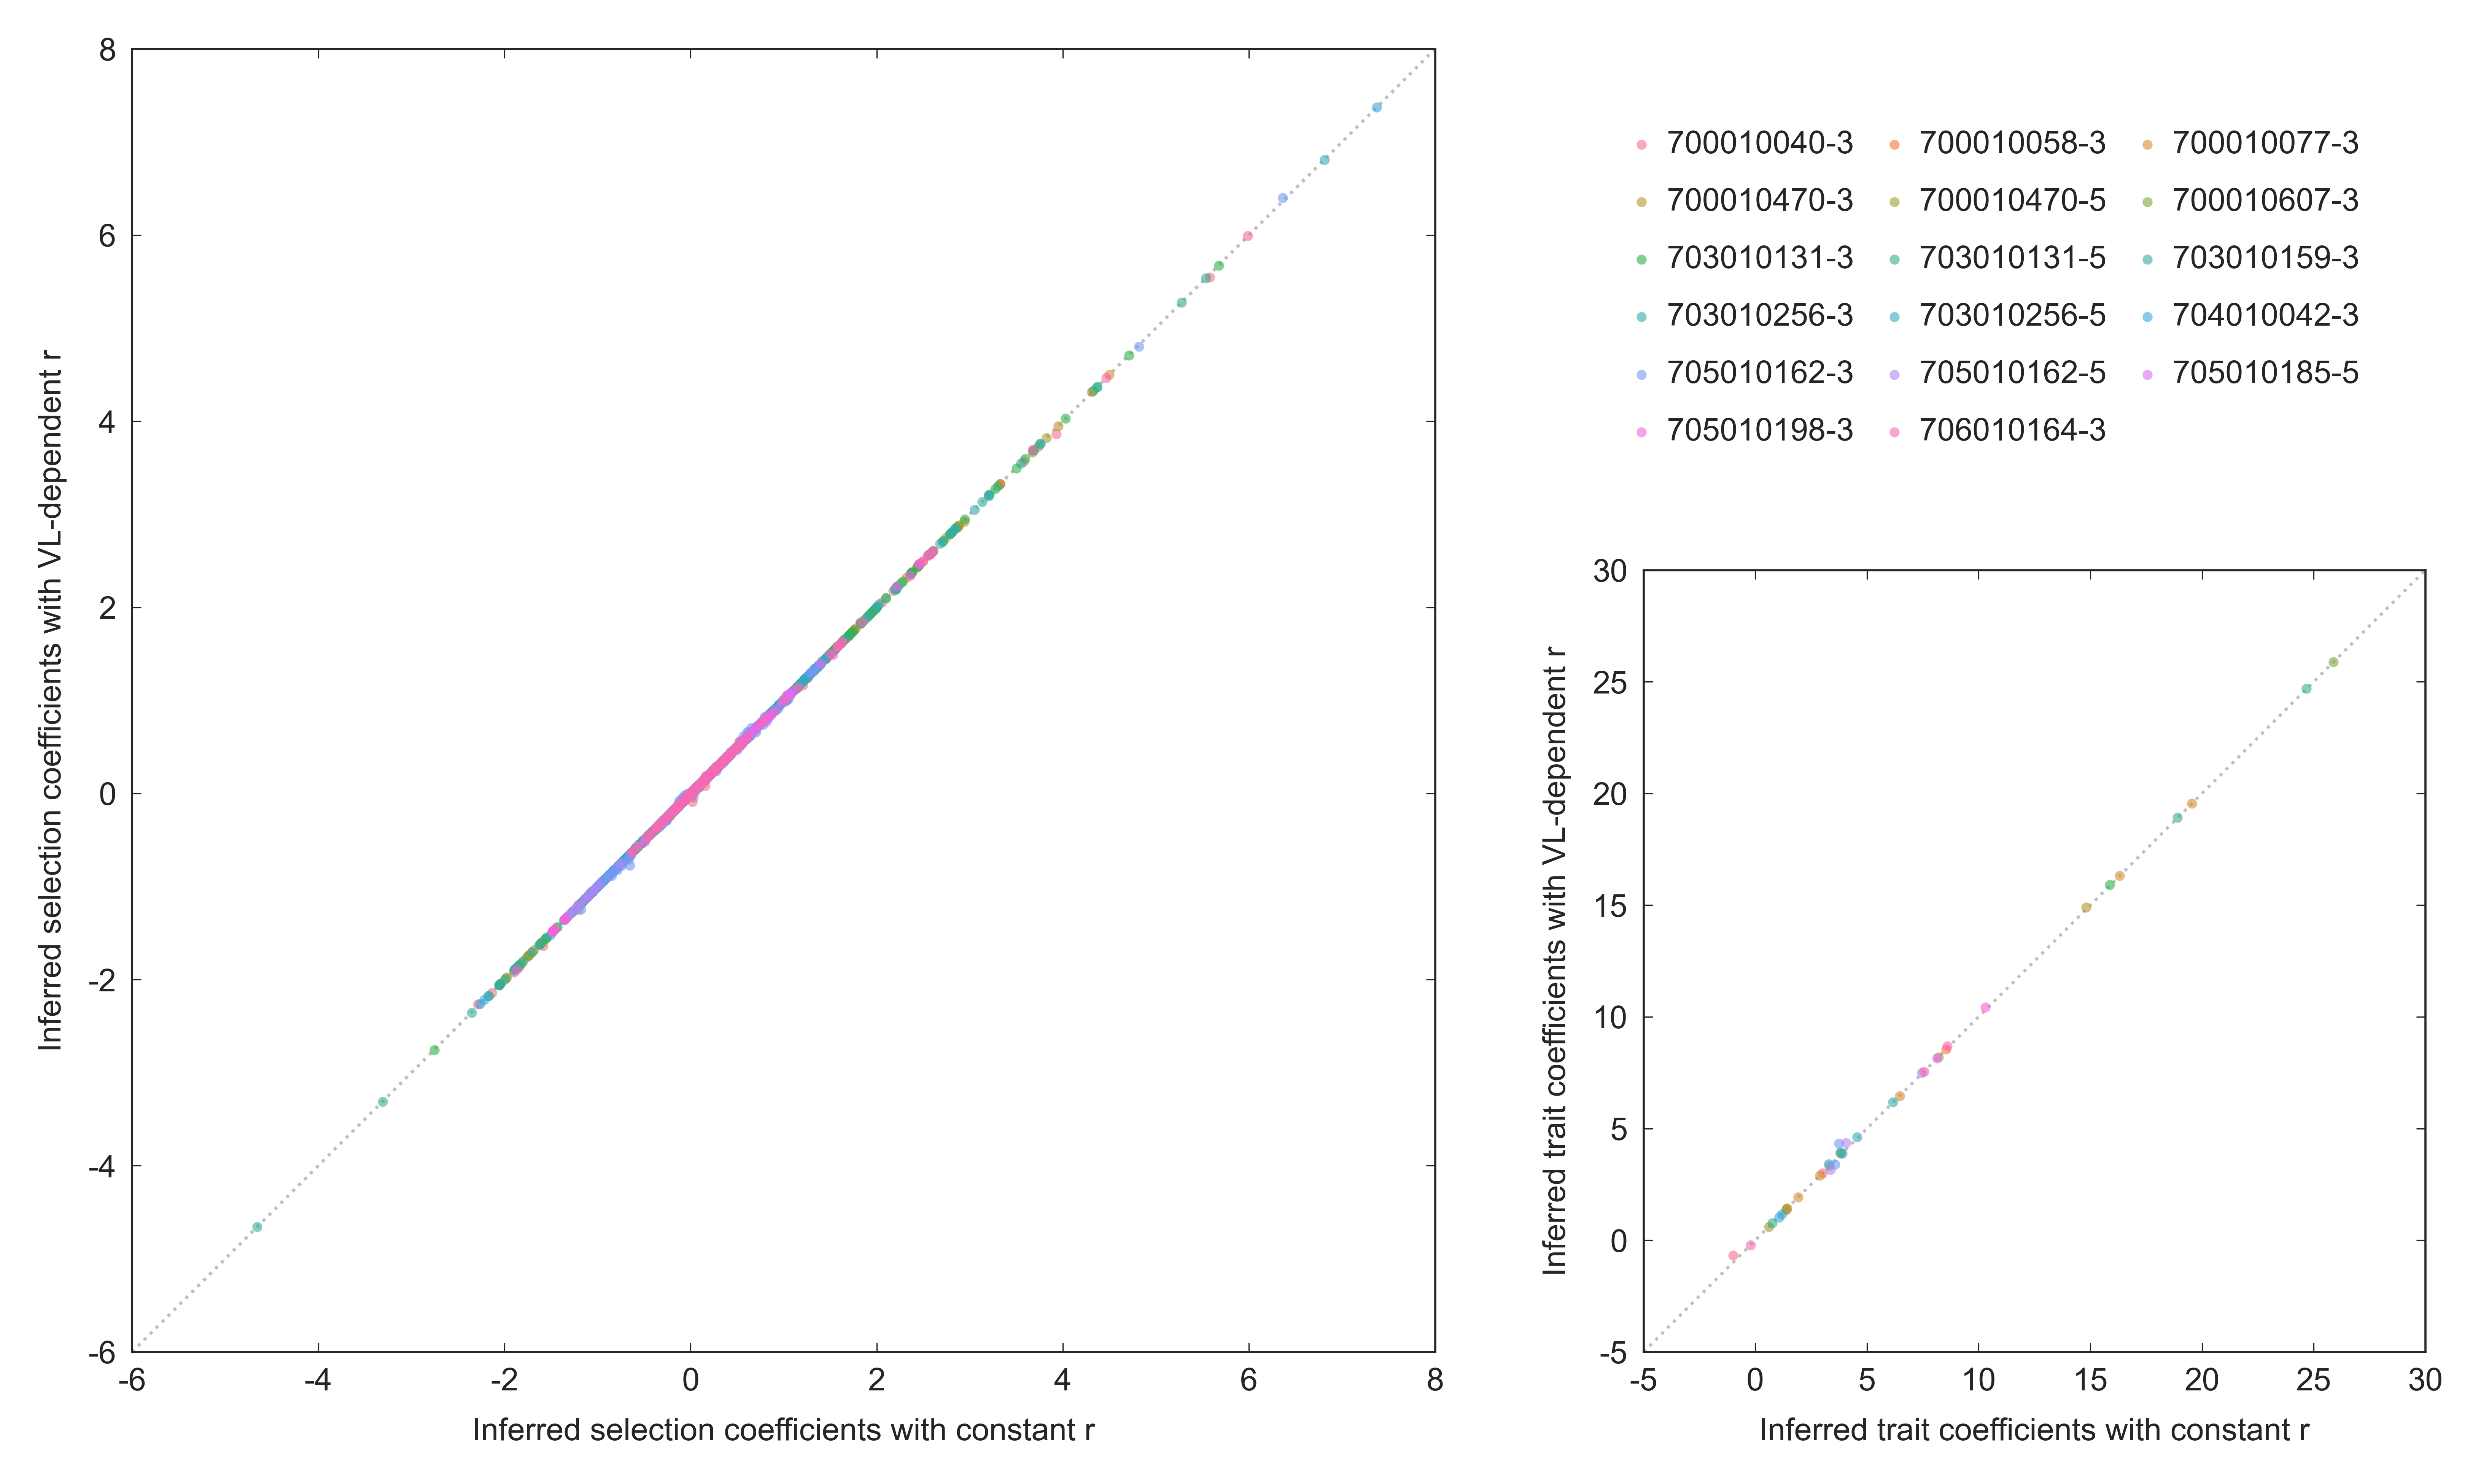

Figure saved as rxfig-HIV-r-VL.pdf


In [15]:
importlib.reload(mp)
importlib.reload(fig)

trait_tags = ['700010040-3', '700010058-3', '700010077-3', '700010470-3', '700010470-5', '700010607-3', 
              '703010131-3', '703010131-5', '703010159-3', '703010256-3', '703010256-5', '704010042-3', 
              '705010162-3', '705010162-5', '705010185-5', '705010198-3', '706010164-3']  

pdata = {
    'tags': trait_tags,    
}

fig.plot_sc_with_VL_r(**pdata)
plt.show()

In [16]:
print('Change more than 10% for selection coefficients for binary trait')
n = 0
max_change = []
for i in range(len(trait_tags)):
    tag = trait_tags[i]
    df_sc = pd.read_csv('%s/rx/constant r/%s-analyze.csv' % (HIV_DIR, tag), comment='#', memory_map=True)

    for ii in range(len(df_sc)):
        if df_sc.iloc[ii].sc_MPL != 0 and df_sc.iloc[ii].nucleotide != '-':
            var_sc = df_sc.loc[ii,'sc_cR']
            var_sc_new = df_sc.loc[ii,'sc_cR']

            if abs(var_sc_new - var_sc) / var_sc > 0.05:
                n += 1
#                 print(f'CH{tag[-5:]} : {df_sc.iloc[ii].polymorphic_index}{df_sc.iloc[ii].nucleotide}\t',end='')
#                 print(f'old {var_sc:.4e},\t new {var_sc_new:.4e},\t {(abs(var_sc_new - var_sc)/ var_sc *100):.2f}%')
#                 max_change.append(abs(var_sc_new - var_sc) / var_sc)

print(n)

Change more than 10% for selection coefficients for binary trait
0


In [17]:
print('Change more than 5% for selection coefficients for binary trait')
for i in range(len(trait_tags)):
    tag = trait_tags[i]
    df_sc = pd.read_csv('%s/rx/constant r/%s-analyze.csv' % (HIV_DIR, tag), comment='#', memory_map=True)
    
    tc_tag = -0.1
    for ii in range(len(df_sc)):
        if pd.isna(df_sc.loc[ii,'tc_MPL']) == False and df_sc.loc[ii,'tc_MPL'] != tc_tag:
            var_tc     = df_sc.loc[ii,'tc_cR']
            var_tc_new = df_sc.loc[ii,'tc_MPL']
            tc_tag = df_sc.loc[ii,'tc_MPL']
            
            if abs(var_tc_new - var_tc) / var_tc > 0.05:
                epitope = df_sc.iloc[ii].epitope
                print(f'CH{tag[-5:]} : {epitope[0]}{epitope[-1]}{len(epitope)}\t',end='')
                print(f'old {var_tc},\t new {var_tc_new}')

Change more than 5% for selection coefficients for binary trait
CH162-3 : EH9	old 0.03745473,	 new 0.0433306
CH162-5 : VD9	old 0.03362371,	 new 0.03152874
CH162-5 : EW9	old 0.04065495,	 new 0.04359198
